In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
sns.set(style = "darkgrid")
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.linear_model import Ridge

In [2]:
#Getting Data
df = pd.read_csv('insurance.csv')

In [3]:
df.drop_duplicates()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [7]:
male = df[df['sex']=='male']
female = df[df['sex']=='female']
df['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [8]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [9]:
df['children'] = df['children'].astype('object')
df['children'].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

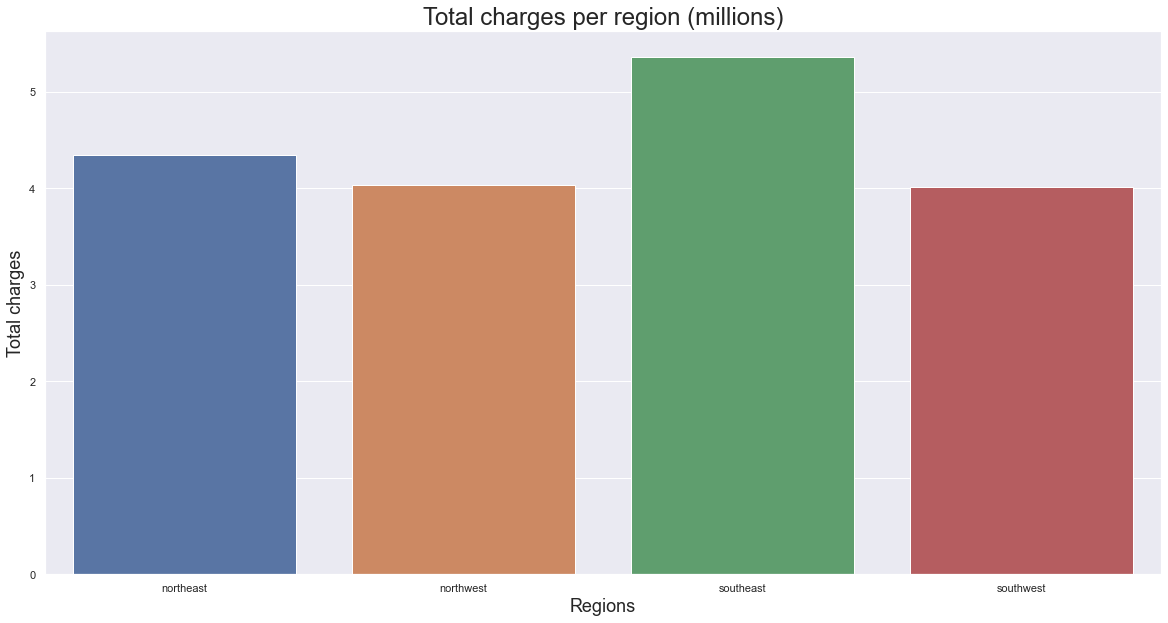

In [10]:
region_cost = df.groupby('region')['charges'].sum() * 1e-6
fig = plt.figure(figsize=(20, 10))
sns.barplot(region_cost.index, region_cost.values)
plt.title("Total charges per region (millions)", size=24)
plt.xlabel('Regions', size=18)
plt.ylabel('Total charges', size=18)
plt.show()

Text(0.5, 1.0, 'Charges and Ages')

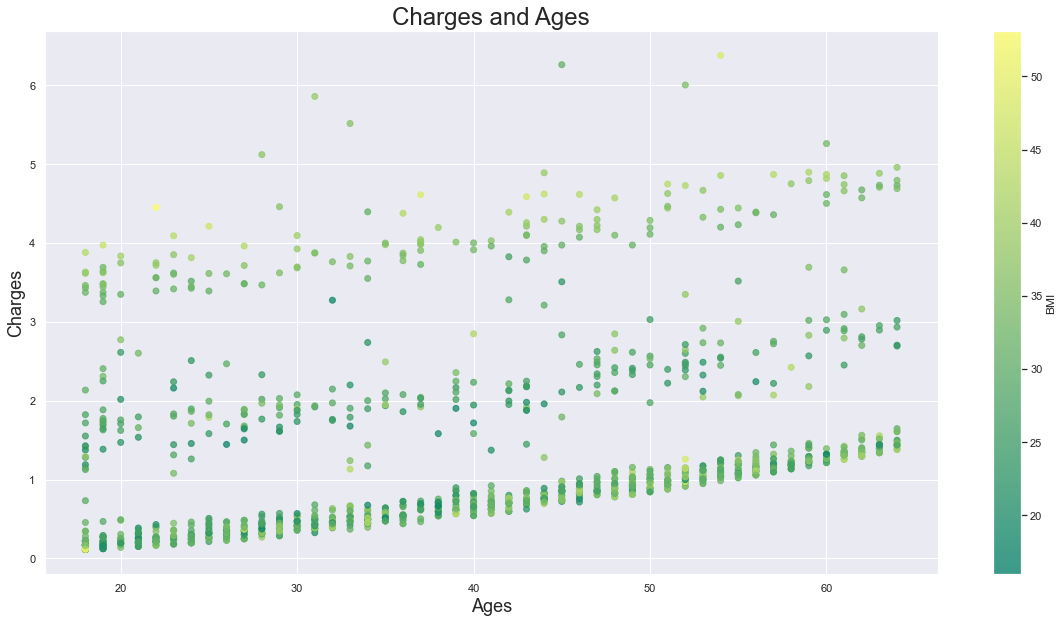

In [11]:
fig = plt.figure(figsize = (20, 10))
plt.scatter(df['age'], df['charges'] * 1e-4, cmap='summer', c=df['bmi'], alpha=0.75)
plt.xlabel('Ages', size=18)
plt.ylabel('Charges', size=18)
plt.colorbar(label='BMI')
plt.title('Charges and Ages', size=24)

In [12]:
df[['charges', 'age']].corr()

,charges,age
charges,1.000000,0.299008
age,0.299008,1.000000


### Người càng lớn tuổi thì chi phí chi trả càng tăng

Text(0.5, 0, 'BMI')

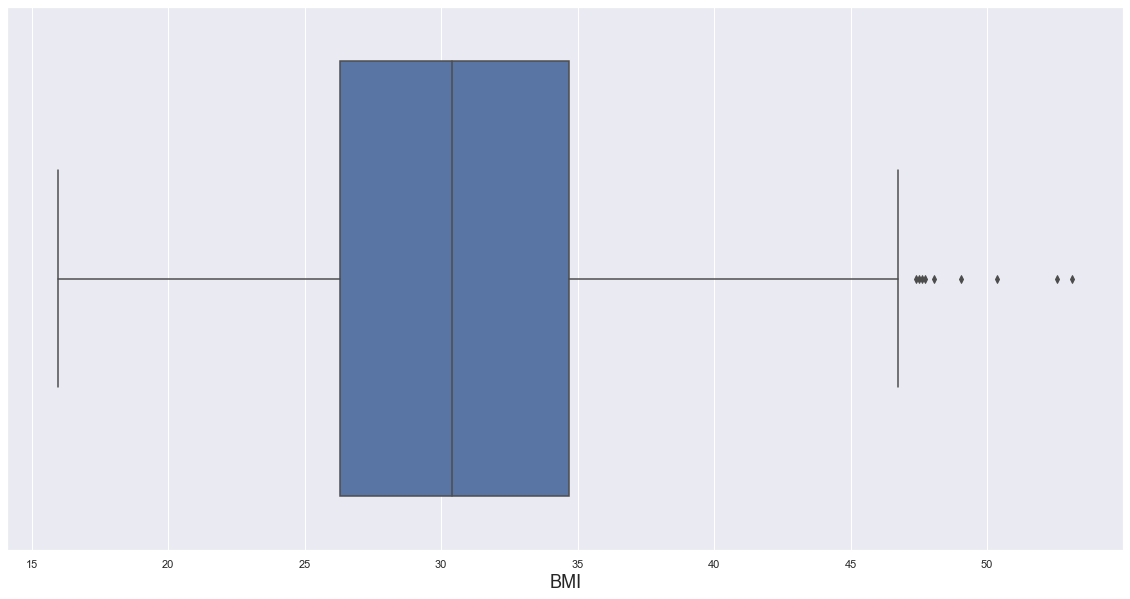

In [13]:
fig = plt.figure(figsize=(20, 10))
sns.boxplot(df['bmi'])
plt.xlabel('BMI', size=18)

Text(0.5, 0, 'Charges')

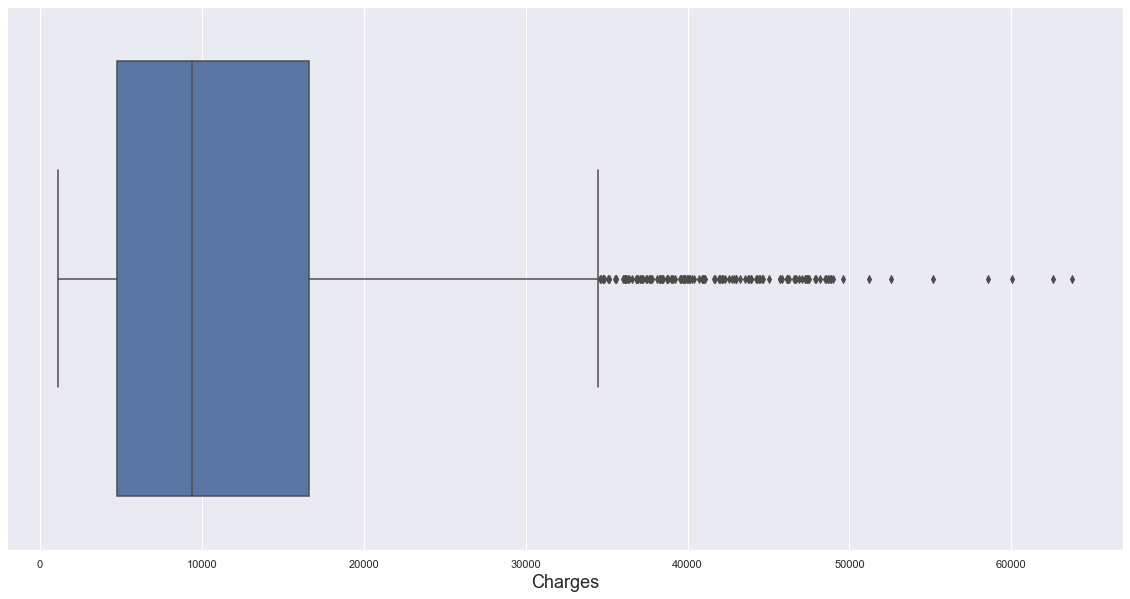

In [14]:
fig = plt.figure(figsize=(20, 10))
sns.boxplot(df['charges'])
plt.xlabel('Charges', size=18)

In [15]:
df.drop(df.query('bmi > 50').index, 0, inplace=True)
df.drop(df.query('charges > 50000').index, 0, inplace=True)

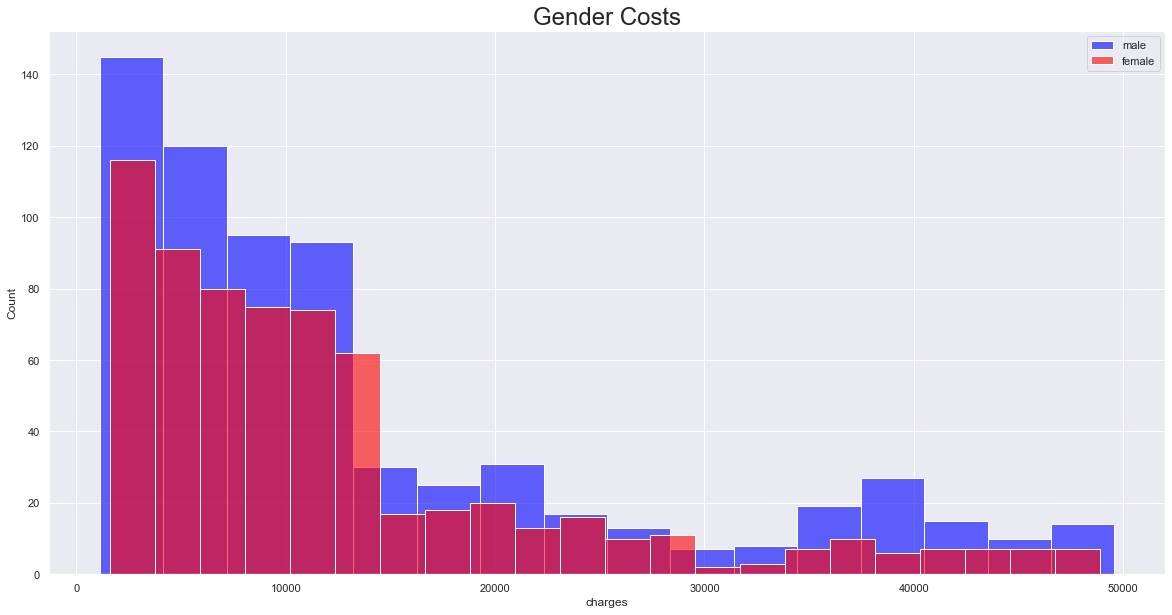

In [16]:
fig = plt.figure(figsize=(20, 10))
sns.histplot(data=df[df['sex']=='male'], x='charges', color='blue', label='male', alpha=0.6)
sns.histplot(data=df[df['sex']=='female'], x='charges', color='red', label='female', alpha=0.6)
plt.title('Gender Costs', size=24)
plt.legend()
plt.show()

### Những bệnh nhân nam trả viện phí cao hơn những bệnh nhân nữ

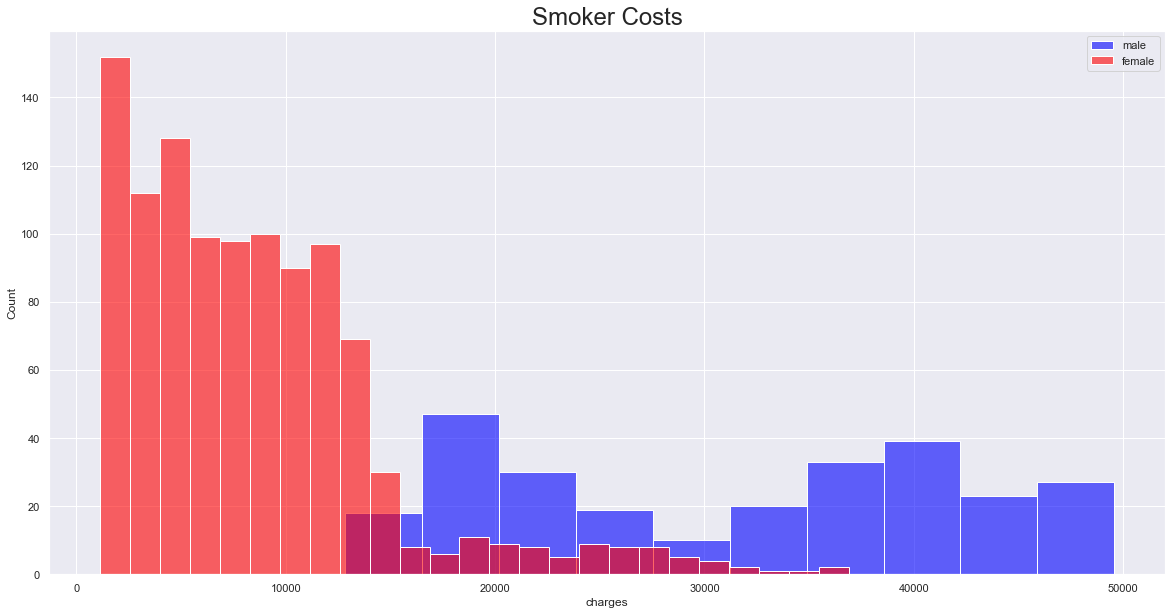

In [17]:
fig = plt.figure(figsize=(20, 10))
sns.histplot(data=df[df['smoker']=='yes'], x='charges', color='blue', label='male', alpha=0.6)
sns.histplot(data=df[df['smoker']=='no'], x='charges', color='red', label='female', alpha=0.6)
plt.title('Smoker Costs', size=24)
plt.legend()
plt.show()

### Những bệnh nhân hút thuốc phải trả viện phí cao hơn những bệnh nhân không hút thuốc

In [18]:
df.drop_duplicates()
df.shape

(1328, 7)

<AxesSubplot:xlabel='bmi', ylabel='charges'>

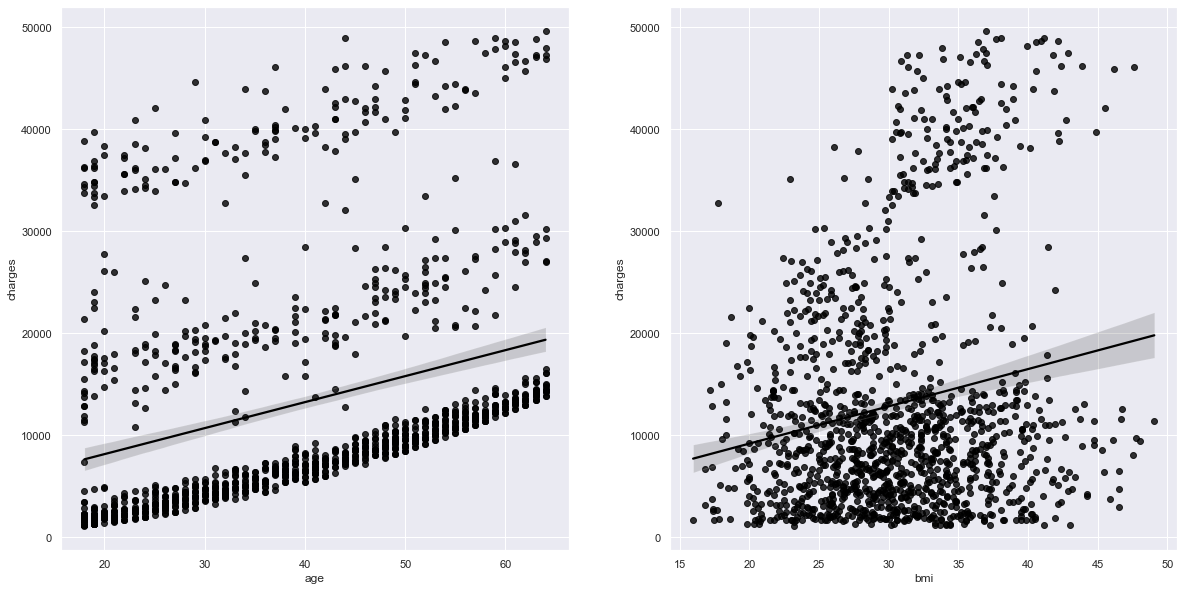

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.regplot(x=df['age'], y=df['charges'], ax=ax[0], color='black')
sns.regplot(x=df['bmi'], y=df['charges'], ax=ax[1], color='black')

Text(0.5, 1.0, 'Probability Plot')

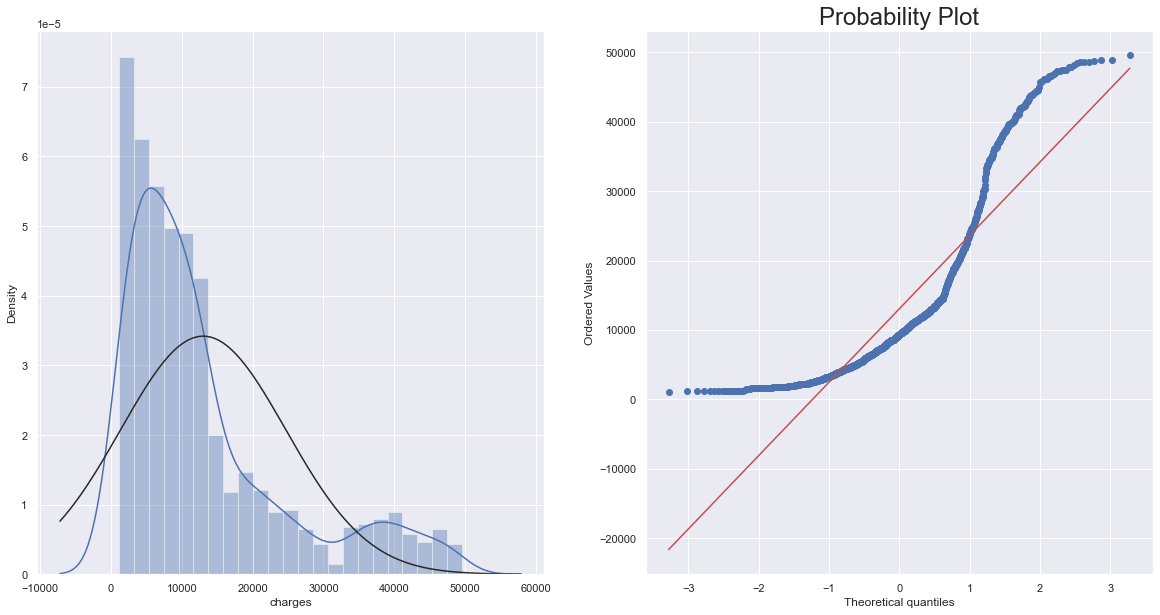

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.distplot(df['charges'], ax=ax[0], fit=stats.norm)
plt.title('Charges Distribution', size=24)
stats.probplot(df['charges'], plot=plt)
plt.title('Probability Plot', size=24)

Text(0.5, 1.0, 'Probability Plot')

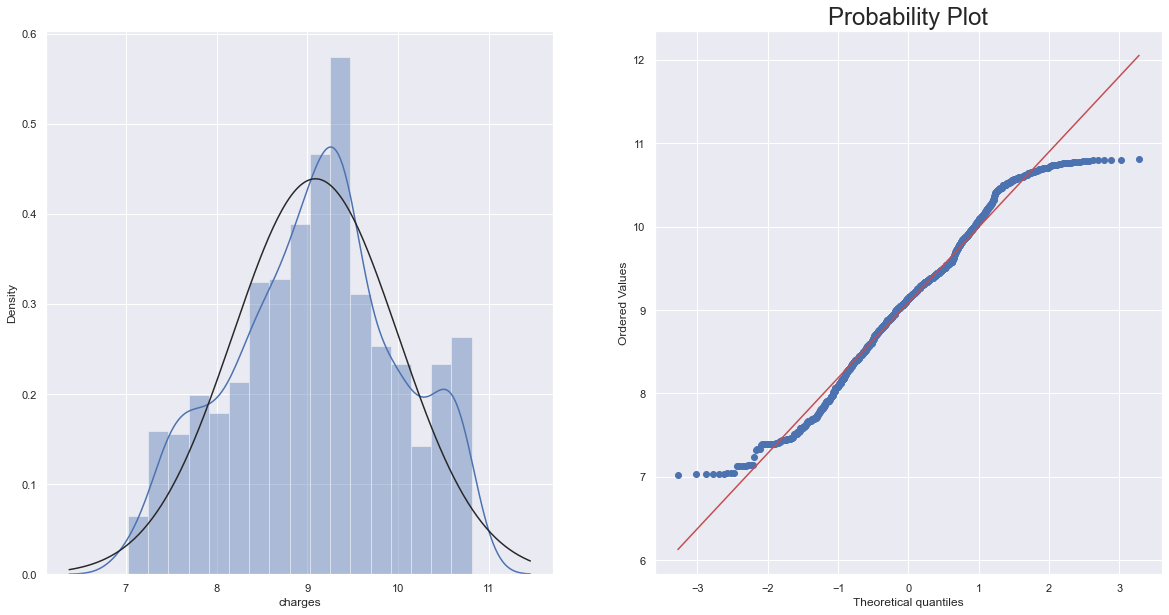

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
charges = np.log1p(df['charges'])
sns.distplot(charges, ax=ax[0], fit=stats.norm)
plt.title('Charges Distribution', size=24)
stats.probplot(charges, plot=plt)
plt.title('Probability Plot', size=24)

In [22]:
numeric_cols = df.dtypes[df.dtypes!='object'].index
skewed_cols = df[numeric_cols].apply(lambda x: stats.skew(x))
skewed_cols

age        0.053660
bmi        0.216400
charges    1.452593
dtype: float64

In [23]:
y = df['charges']
X = df.drop('charges', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=True)

In [36]:
pipeline = Pipeline(
    [
    ("CT", ColumnTransformer(
            [
                ("OHE", OneHotEncoder(), df.select_dtypes('object').columns),
                ("SCL", StandardScaler(), ['bmi'])
            ],
            remainder = 'passthrough')),
    ("PF", PolynomialFeatures(2)),
    ("TTR", TransformedTargetRegressor(
            regressor=Ridge(), 
            func=np.log1p, 
            inverse_func=np.expm1))
    ]
)

In [37]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(r2_score(y_pred, y_test))

0.8302268935728062


In [38]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'CT', 'PF', 'TTR', 'CT__n_jobs', 'CT__remainder', 'CT__sparse_threshold', 'CT__transformer_weights', 'CT__transformers', 'CT__verbose', 'CT__OHE', 'CT__SCL', 'CT__OHE__categories', 'CT__OHE__drop', 'CT__OHE__dtype', 'CT__OHE__handle_unknown', 'CT__OHE__sparse', 'CT__SCL__copy', 'CT__SCL__with_mean', 'CT__SCL__with_std', 'PF__degree', 'PF__include_bias', 'PF__interaction_only', 'PF__order', 'TTR__check_inverse', 'TTR__func', 'TTR__inverse_func', 'TTR__regressor__alpha', 'TTR__regressor__copy_X', 'TTR__regressor__fit_intercept', 'TTR__regressor__max_iter', 'TTR__regressor__normalize', 'TTR__regressor__random_state', 'TTR__regressor__solver', 'TTR__regressor__tol', 'TTR__regressor', 'TTR__transformer'])

In [39]:
pipeline_params = {
    'PF__degree':[2, 3, 4],
    'TTR__regressor__alpha':[0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5]
}
grid_search = GridSearchCV(pipeline, pipeline_params, scoring=mean_squared_error)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'PF__degree': 2, 'TTR__regressor__alpha': 0.01}
